# Calculate sea water volume from bathymetry

## Data preparation
We use [ETOPO1 data](https://www.ngdc.noaa.gov/mgg/global/) provided by NOAA.

Data is available from [here](https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/ice_surface/grid_registered/georeferenced_tiff/ETOPO1_Ice_g_geotiff.zip) and extract `.tiff` file to `data` directory.

tiff file were warped to Mollweide projection with the following command.
```
gdalwarp -s_srs EPSG:4326 -t_srs ESRI:54009 -dstnodata -32768.0 -r near \
-of GTiff ETOPO1_Ice_g_geotiff.tif ETOPO_mollweide.tif
```

## Import required libraries

In [1]:
from rasterio.plot import show
import numpy as np
import rasterio
from rasterio.warp import (calculate_default_transform,
                           reproject,
                           Resampling)
import matplotlib.pyplot as plt

## Read ETOPO data

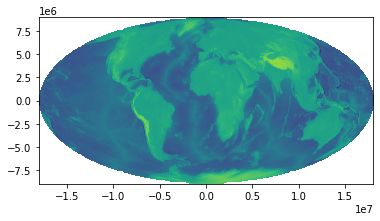

In [2]:
raster_path = 'data/ETOPO_mollweide.tif'
with rasterio.open(raster_path) as src:
    raster_array = src.read(1)
    raster_profile = src.profile
    raster_res = src.res
    show(src)

## Remove land area

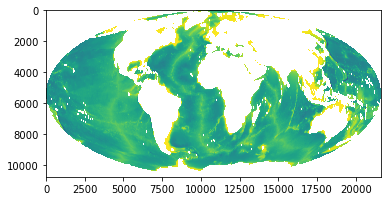

In [3]:
raster_array = np.where(raster_array == raster_profile['nodata'],
                        np.nan, raster_array)

# Remove above 0m area. This will not remove inland low land area. 
raster_array = np.where(raster_array >= 0, np.nan, raster_array)
plt.imshow(raster_array)

## Calculate sea area and volume

In [4]:
# pixel size in km^2
pixel_size = raster_res[0] * raster_res[1] / 1_000_000

sea_area = (~np.isnan(raster_array)).sum() * pixel_size
print('Total sea area is ' 
      f'{np.format_float_scientific(sea_area, precision=3)} km^2.')

# Total sea water volume
sea_volume = -np.nansum(raster_array) / 1000 * pixel_size
print('Total sea volume is' 
      f'{np.format_float_scientific(sea_volume, precision=3)} km^3')

Total sea area is 3.622e+08 km^2.
Total sea volume is1.336e+09 km^3


In [5]:
# volume above depth_bottom
def calc_water_volume_above_threshold(
    bathymetric_array: np.array,
    pixel_size: float,
    threshold: float = None) -> np.float64:
    
    """
    Args:
        bathymetric_array:
            negative values in meter
        threshold:
            negative value in meter
        pixel_size:
            km^2
    Return:
        Volume in km^3
    """

    if threshold is not None:
        if threshold > 0:
            raise ValueError('threshold should be negative value.')
        bathymetric_array = np.where(bathymetric_array < threshold,
                                     threshold, bathymetric_array)
    return -np.nansum(bathymetric_array) / 1000 * pixel_size

In [6]:
depths = [-200, -1000, -4000, -6000, -10000]
volumes = []

for depth in depths:
    volume = calc_water_volume_above_threshold(raster_array,
                                               pixel_size,
                                               threshold=depth)
    volumes.append(volume)

In [7]:
# print results
for depth, volume in zip(depths, volumes):
    print(f'Sea water volume above {depth}m is '
          f'{np.format_float_scientific(volume, 3)} km^3')
    print(f'It\'s {np.format_float_positional((volume / sea_volume * 100), 1)} '
         '% of total sea water.\n')

Sea water volume above -200m is 6.880e+07 km^3
It's 5.2 % of total sea water.

Sea water volume above -1000m is 3.296e+08 km^3
It's 24.7 % of total sea water.

Sea water volume above -4000m is 1.169e+09 km^3
It's 87.5 % of total sea water.

Sea water volume above -6000m is 1.334e+09 km^3
It's 99.9 % of total sea water.

Sea water volume above -10000m is 1.336e+09 km^3
It's 100. % of total sea water.



## Other stats

In [8]:
# sea area which depth is deeper than 1000m.
(raster_array < -1000).sum() * pixel_size / sea_area

0.8828970609869402